<h4>AŞAMALAR</h4>
<li> Veriyi oluştur
<li> 180 farklı açı ile radon dönüşümü yapıp sinogram görüntüsünü oluştur
<li> Kartezyen koordinat sistemi görüntüsü
<li> Fourier Dönüşümü ile sinogramın zaman uzayından frekans uzayına dönüştürülmesi
<li> Polar koordinat sistemi ile görüntü
<li> Filtrelemeler ile görüntüyü iyileştirme
<li> Ters fouirer ile geri zaman uzayına alma aşaması
<li> Ters radon alınması
<li> CTScan sonuç görüntüsü

### Kütüphanelerin Dahil Edilmesi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon
from numpy.fft import fft2, ifft2, fftshift, ifftshift, ifft, fft
from skimage.metrics import mean_squared_error

### Görüntüleme Fonksiyonlarının Oluşturulması

In [2]:
def ShowInCartezianCoordinatSystem(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()

In [3]:
def ShowInPolarCoordinatSystem(image, title):
    plt.imshow(np.abs(image))
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Theta')
    plt.ylabel('Radius')
    plt.show()

### Radon dönüşümü
* linspace() fonksiyponu [start, stop] aralığı üzerinden hesaplanan eşit aralıklı örnekleri döndürür. Hastadan 0-179 derece arasındaki 180 adet açıdan alacağımız örnek kesitleri bu fonksiyon ile elde etmekteyiz.
* linspace'den dönen 180 kesit örneğini radon() fonksiyonuna vererek bu görüntülerden sinogram görüntüsünü elde ediyoruz.
* linspace() fonksiyonundaki endpoint parametresi end_angle'ın dahil edilip edilmeyeceğini belirtmektedir. Burada dahil edilmemiştir.
* num parametresi ise oluşturulan örneklerin sayısını belirtir.
* radon() fonksiyonundaki circle parametresi Radon dönüşümünün bir daire şeklinde gerçekleştirileceğini belirtir. Bu, eğer giriş görüntüsü bir daire şeklinde ise daha doğru sonuçlar almak için kullanılır.

In [4]:
def RadonTransformation(image, start_angle=0., end_angle=180.):
    section_samples = np.linspace(start=start_angle, stop=end_angle, num=max(image.shape), endpoint=False)
    sinogram = radon(image, theta=section_samples, circle=True)
    return sinogram

### Görüntüyü normalize etme aşaması
* İlk adımda sinogramdaki en küçük değerler çıkarılarak negatif değerlerin oluşması engellenir.
* İkinci adımda ise görüntü değerleri 0-1 arasına çekilerek sıkıştırılır. Böylece her değerin etki etme olasılığı arttırılır.

In [5]:
def normalize_sinogram(image):
    image -= np.min(image)
    image /= np.max(image)
    return image

### Fourier Dönüşümü
* bu fonksiyonda gelen girdinin iki boyutlu fourier dönüşümü alınarak zaman uzayından frekans uzayına çekilir.
* ardından frekans bilgisini merkezde toplanmak üzere shift edilir.
* Üçüncü adımda, dönüşüm sonucu elde edilen karmaşık sayı dizisinin genlik spektrumu hesaplanır. 
* Dördüncü adımda, genlik spektrumunun logaritması alınarak, daha iyi görselleştirilebilir bir hale getirilir. Logaritma alınması, spektrumdaki büyük değerlerin daha düşük bir ölçekte ifade edilmesini sağlar ve bu sayede görüntünün daha iyi analiz edilmesini kolaylaştırır.

In [6]:
def FourierTransformation2D(image):
    
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shifted)
    log_magnitude_spectrum = np.log(1 + magnitude_spectrum)

    return log_magnitude_spectrum, f_transform_shifted

### Görüntünün İyileştirilmesi İçin Filtreler
* cosine, rampa ve cutoff frequency filtreleri kullannılmıştır.

##### cosine
* Frekans alanında bir kosinüs fonksiyonu ile frekans bileşenlerini kırpar.
* Yüksek frekanslı bileşenleri yumuşatır.

##### rampa
* Doğrusal bir şekilde frekans bileşenlerini kırpar.
* Yüksek frekanslı gürültüleri ve ayrıntıları azaltırken düşük frekansları korur.

##### cutoff frequency
* Belirli bir kesme frekansından büyük olan frekans bileşenlerini kırpar. Görüntüdeki belirli frekans aralıklarının vurgulanması veya bastırılması gerektiğinde tercih edilir. parametre olarak genelde örnekleme frekansının yarısı kullanılır.


In [7]:
def Filter(f_transform, filter_type, cutoff_freq=None, slope=None):
    filter_types = ('ramp', 'cosine', 'cutoff_frequency', 'slope', None)
    if filter_type not in filter_types:
        raise ValueError(f"Unknown filter: {filter_type}")
    
    rows, cols = f_transform.shape
    center_row, center_col = rows // 2, cols // 2
    
    # Frequency scaling factors
    u = np.fft.fftfreq(rows).reshape(-1, 1)
    v = np.fft.fftfreq(cols).reshape(1, -1)
    radius = np.sqrt(u**2 + v**2)
    
    # Generate the filter
    if filter_type == 'ramp':
        filter_mask = radius
    elif filter_type == 'cosine':
        filter_mask = np.cos(np.pi * radius / 2)
    elif filter_type == 'cutoff_frequency':
        if cutoff_freq is None:
            raise ValueError("Cutoff frequency must be specified for cutoff_frequency filter.")
        filter_mask = np.ones_like(f_transform)
        filter_mask[radius > cutoff_freq] = 0
    elif filter_type == 'slope':
        if cutoff_freq is None or slope is None:
            raise ValueError("Cutoff frequency and slope must be specified for slope filter.")
        filter_mask = 1 / (1 + (radius / cutoff_freq) ** (2 * slope))
    else:
        filter_mask = np.ones_like(f_transform)
    
    # Apply the filter
    filtered_image = f_transform * filter_mask
    return filtered_image



### Ters Fourier Dönüşümü

In [8]:
def InverseFourierTransformation(f_transform):
    f_transform_shifted = np.fft.ifftshift(f_transform)
    inverse_f_transform = ifft2(f_transform_shifted).real
    return inverse_f_transform

### Sonuçta Elde Edilen Görüntünün Hata Oranın Ölçümü İçin Karelerin Ortalaması Yöntemi

In [9]:
# Performans ölçümü
def ErrorRate(input_image, output_image):
    mse = mean_squared_error(input_image, output_image)
    print(f"Mean Squared Error: {mse}")
    return mse

# CTScan System

* Radon dönüşümü, orijinal görüntüyü projeksiyonlara dönüştürür. Ters Radon dönüşümü, bu projeksiyonları kullanarak orijinal görüntüyü geri oluşturur. 

In [10]:
def CTScan(input_image, filter_type= None, cutoff_freq=None, slope=None):
    # Show Input Image
    ShowInCartezianCoordinatSystem(image=input_image, title="Input Image")

    # Radon Transformation
    sinogram = RadonTransformation(input_image)
    
    # Show sinogram image in Cartezian Coordinat System
    ShowInCartezianCoordinatSystem(sinogram, "Sinogram Image After Radon Transform")

    # Normalize the sinogram image
    normalized_sinogram = normalize_sinogram(sinogram)
    
    # 2D Fourier Transform
    magnitude, fourier_2d = FourierTransformation2D(normalized_sinogram)

    # Show Fourier result in Polar Coordinat System
    ShowInPolarCoordinatSystem(magnitude, 'Magnitude of Interpolated FFT2')
    
    # Filtration
    filtered_fourier = Filter(fourier_2d,filter_type, cutoff_freq= 90 )
    
    # Inverse Fourier Transform
    inverse_fourier = InverseFourierTransformation(filtered_fourier)

    # Inverse Radon Transformation
    reconstructed_image = iradon(inverse_fourier, circle=True)

    # Normalize the reconstructed image
    normalized_reconstructed = normalize_sinogram(reconstructed_image)
    
    # Show the result image in Cartezian Coordinat System
    ShowInCartezianCoordinatSystem(normalized_reconstructed, "Reconstructed Image")

    # Measuring the performance
    ErrorRate(input_image, normalized_reconstructed)

In [11]:
# sisteme girdi olacak olan görüntü verisinin oluşturulması
input_image = shepp_logan_phantom()

### with no filter CTScan

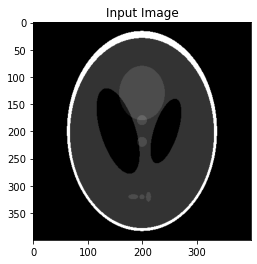

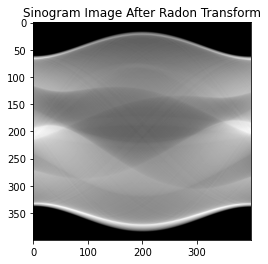

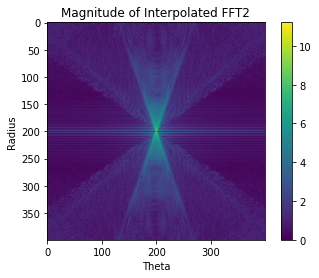

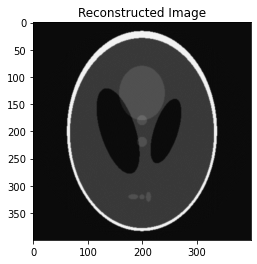

Mean Squared Error: 0.0026190583689824705


In [12]:
CTScan(input_image)

### with ramp filter CTScan

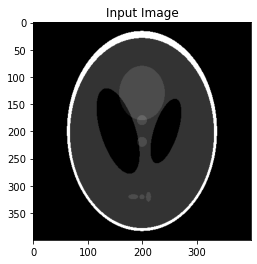

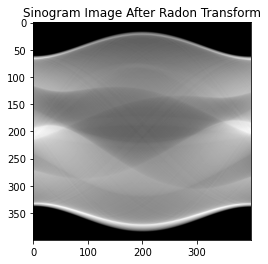

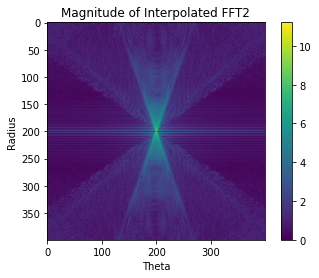

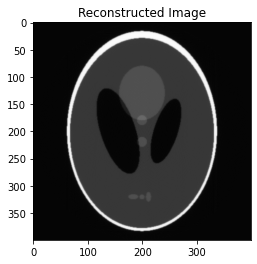

Mean Squared Error: 0.002125650832305894


In [13]:
CTScan(input_image, "ramp")

### with cosine filter CTScan

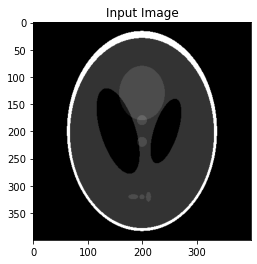

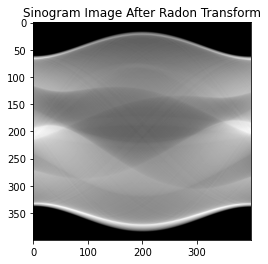

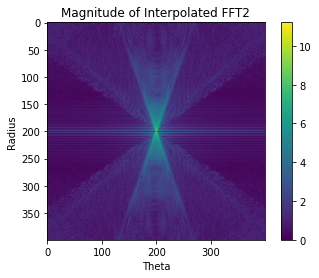

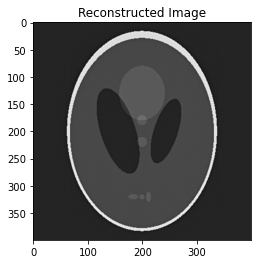

Mean Squared Error: 0.014999664797931644


In [14]:
CTScan(input_image, "cosine")

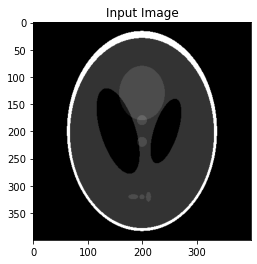

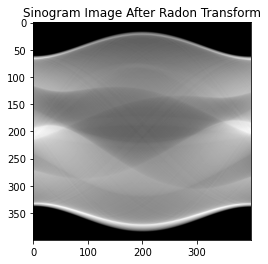

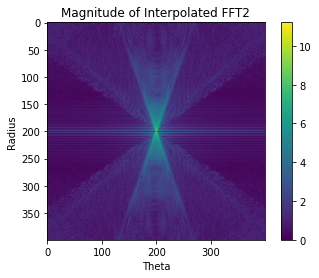

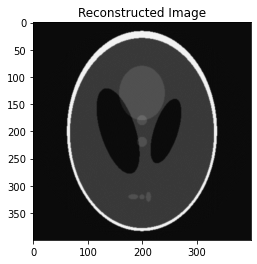

Mean Squared Error: 0.0026190583689824705


In [26]:
CTScan(input_image, "cutoff_frequency", cutoff_freq= 90)

## shep_logan result examining 

In [15]:
def CTScan_withoutNormalizing(input_image, filter_type= None, cutoff_freq=None, slope=None):

    # Randon Transformation
    sinogram = RadonTransformation(input_image)
    
    # 2D Fourier Transform
    magnitude, fourier_2d = FourierTransformation2D(sinogram)
    
    # Filtreleme
    filtered_fourier = Filter(fourier_2d,filter_type, cutoff_freq )
    
    # Inverse Fourier Transform
    inverse_fourier = InverseFourierTransformation(filtered_fourier)

    # Ters Radon Transformasyonu (Filtreli Geri Projeksiyon)
    reconstructed_image = iradon(inverse_fourier, circle=True)

    # Performans ölçümü
    error_rate = ErrorRate(input_image, reconstructed_image)
    return error_rate


In [16]:
def CTScan_withNormalizing(input_image, filter_type= None, cutoff_freq=None):

    # Randon Transformation
    sinogram = RadonTransformation(input_image)

    # Normalize the sinogram image
    normalized_sinogram = normalize_sinogram(sinogram)
    
    # 2D Fourier Transform
    magnitude, fourier_2d = FourierTransformation2D(normalized_sinogram)
    
    # Filtreleme
    filtered_fourier = Filter(fourier_2d,filter_type,cutoff_freq )
    
    # Inverse Fourier Transform
    inverse_fourier = InverseFourierTransformation(filtered_fourier)

    # Ters Radon Transformasyonu (Filtreli Geri Projeksiyon)
    reconstructed_image = iradon(inverse_fourier, circle=True)

    # Normalize the reconstructed image
    normalized_reconstructed = normalize_sinogram(reconstructed_image)

    # Performans ölçümü
    error_rate = ErrorRate(input_image, normalized_reconstructed)
    return error_rate

In [17]:
print("CTScan result without any filter and normalizing:")
error1 = CTScan_withoutNormalizing(input_image)
print()
print("CTScan result without normalizing and ramp filter:")
error2= CTScan_withoutNormalizing(input_image, "ramp")
print()
print("CTScan result without normalizing and cosine filter:")
error3= CTScan_withoutNormalizing(input_image, "cosine")
print()
print("CTScan result without normalizing and cutoff_frequency (90) filter:")
error4= CTScan_withoutNormalizing(input_image, "cutoff_frequency", cutoff_freq= 90)
print()


print("CTScan result with normalizing and any filter:")
error6= CTScan_withNormalizing(input_image)
print()
print("CTScan result with ramp filter and normalizing:")
error7= CTScan_withNormalizing(input_image, "ramp")
print()
print("CTScan result with cosine filter and normalizing:")
error8= CTScan_withNormalizing(input_image, "cosine")
print("CTScan result with normalizing and cutoff_frequency (90) filter:")
error9= CTScan_withNormalizing(input_image, "cutoff_frequency", cutoff_freq= 90)
print()

CTScan result without any filter and normalizing:
Mean Squared Error: 0.0009416523761851609

CTScan result without normalizing and ramp filter:
Mean Squared Error: 0.007811697234045731

CTScan result without normalizing and cosine filter:
Mean Squared Error: 0.017746942589441875

CTScan result without normalizing and cutoff_frequency (90) filter:
Mean Squared Error: 0.0009416523761851609

CTScan result with normalizing and any filter:
Mean Squared Error: 0.0026190583689824705

CTScan result with ramp filter and normalizing:
Mean Squared Error: 0.002125650832305894

CTScan result with cosine filter and normalizing:
Mean Squared Error: 0.014999664797931644
CTScan result with normalizing and cutoff_frequency (90) filter:
Mean Squared Error: 0.0026190583689824705



In [18]:
import pandas as pd

# Verileri oluştur
data = {
    'Filter': ['None', 'Ramp', 'Cosine', 'Cutoff Frequency', 'None', 'Ramp', 'Cosine', 'Cutoff Frequency'],
    'Normalization': ['None', 'None', 'None', 'None', 'Normalizing', 'Normalizing','Normalizing', 'Normalizing'],
    'Error': [error1, error2, error3, error4,  error6, error7, error8, error9]
}

# DataFrame oluştur
df = pd.DataFrame(data)

# DataFrame'i görüntüle
print(df)

             Filter Normalization     Error
0              None          None  0.000942
1              Ramp          None  0.007812
2            Cosine          None  0.017747
3  Cutoff Frequency          None  0.000942
4              None   Normalizing  0.002619
5              Ramp   Normalizing  0.002126
6            Cosine   Normalizing  0.015000
7  Cutoff Frequency   Normalizing  0.002619


In [19]:
error_list= [{"CTScan without any filter and normalizing": error1},
             {"CTScan without normalizing and ramp filter": error2},
             {"CTScan without normalizing and cosine filter": error3},
             {"CTScan without normalizing and cutoff_frequency (90) filter": error4},
             {"CTScan with normalizing and any filter": error6},
             {"CTScan with ramp filter and normalizing": error7},
             {"CTScan with cosine filter and normalizing": error8},
             {"CTScan with normalizing and cutoff_frequency (90) filter": error9}]

print("With sheep_logan_image")
ordered_list = sorted(error_list, key=lambda x: list(x.values())[0])
for i in ordered_list:
    print(i)

With sheep_logan_image
{'CTScan without any filter and normalizing': 0.0009416523761851609}
{'CTScan without normalizing and cutoff_frequency (90) filter': 0.0009416523761851609}
{'CTScan with ramp filter and normalizing': 0.002125650832305894}
{'CTScan with normalizing and any filter': 0.0026190583689824705}
{'CTScan with normalizing and cutoff_frequency (90) filter': 0.0026190583689824705}
{'CTScan without normalizing and ramp filter': 0.007811697234045731}
{'CTScan with cosine filter and normalizing': 0.014999664797931644}
{'CTScan without normalizing and cosine filter': 0.017746942589441875}


## example image result examining

In [20]:
import os 
import imageio 
from skimage.transform import resize

def load_image(path):
       phantom =  imageio.imread(path)
       phantom = resize(phantom, (256, 256), mode='reflect', anti_aliasing=True)
       return phantom

path = os.path.join(os.getcwd(), 'exp1.png')
input_image2= load_image(path)

C:\Users\Pc\AppData\Local\Temp\ipykernel_18980\2331747080.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  phantom =  imageio.imread(path)


In [21]:
print("CTScan result without any filter and normalizing:")
error11 = CTScan_withoutNormalizing(input_image2)
print()
print("CTScan result without normalizing and ramp filter:")
error12= CTScan_withoutNormalizing(input_image2, "ramp")
print()
print("CTScan result without normalizing and cosine filter:")
error13= CTScan_withoutNormalizing(input_image2, "cosine")
print()
print("CTScan result without normalizing and cutoff_frequency (90) filter:")
error14= CTScan_withoutNormalizing(input_image2, "cutoff_frequency", cutoff_freq= 90)
print()
print()


print("CTScan result with normalizing and any filter:")
error16= CTScan_withNormalizing(input_image2)
print()
print("CTScan result with ramp filter and normalizing:")
error17= CTScan_withNormalizing(input_image2, "ramp")
print()
print("CTScan result with cosine filter and normalizing:")
error18= CTScan_withNormalizing(input_image2, "cosine")
print()
print("CTScan result with normalizing and cutoff_frequency (90) filter:")
error19= CTScan_withNormalizing(input_image2, "cutoff_frequency", cutoff_freq= 90)
print()

CTScan result without any filter and normalizing:


c:\Users\Pc\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Mean Squared Error: 0.00046853429475992333

CTScan result without normalizing and ramp filter:
Mean Squared Error: 0.008419711488239279

CTScan result without normalizing and cosine filter:
Mean Squared Error: 0.02336199176357706

CTScan result without normalizing and cutoff_frequency (90) filter:
Mean Squared Error: 0.00046853429475992333


CTScan result with normalizing and any filter:
Mean Squared Error: 0.0014516950707262166

CTScan result with ramp filter and normalizing:
Mean Squared Error: 0.0012823701377916905

CTScan result with cosine filter and normalizing:
Mean Squared Error: 0.005430138758188569

CTScan result with normalizing and cutoff_frequency (90) filter:
Mean Squared Error: 0.0014516950707262166



In [22]:
error_list2= [{"CTScan without any filter and normalizing": error11},
             {"CTScan without normalizing and ramp filter": error12},
             {"CTScan without normalizing and cosine filter": error13},
             {"CTScan without normalizing and cutoff_frequency (90) filter": error14},
             {"CTScan with normalizing and any filter": error16},
             {"CTScan with ramp filter and normalizing": error17},
             {"CTScan with cosine filter and normalizing": error18},
             {"CTScan with normalizing and cutoff_frequency (90) filter": error19}]

print("With Exapmle Image")
ordered_list2 = sorted(error_list2, key=lambda x: list(x.values())[0])
for i in ordered_list2:
    print(i)

With Exapmle Image
{'CTScan without any filter and normalizing': 0.00046853429475992333}
{'CTScan without normalizing and cutoff_frequency (90) filter': 0.00046853429475992333}
{'CTScan with ramp filter and normalizing': 0.0012823701377916905}
{'CTScan with normalizing and any filter': 0.0014516950707262166}
{'CTScan with normalizing and cutoff_frequency (90) filter': 0.0014516950707262166}
{'CTScan with cosine filter and normalizing': 0.005430138758188569}
{'CTScan without normalizing and ramp filter': 0.008419711488239279}
{'CTScan without normalizing and cosine filter': 0.02336199176357706}


In [23]:

# Verileri oluştur
data2 = {
    'Filter': ['None', 'Ramp', 'Cosine', 'Cutoff Frequency', 'None', 'Ramp', 'Cosine', 'Cutoff Frequency'],
    'Normalization': ['None', 'None', 'None', 'None', 'Normalizing', 'Normalizing','Normalizing', 'Normalizing'],
    'Error': [error11, error12, error13, error14,  error16, error17, error18, error19]
}

# DataFrame oluştur
df2 = pd.DataFrame(data)

# DataFrame'i görüntüle
print(df2)

             Filter Normalization     Error
0              None          None  0.000942
1              Ramp          None  0.007812
2            Cosine          None  0.017747
3  Cutoff Frequency          None  0.000942
4              None   Normalizing  0.002619
5              Ramp   Normalizing  0.002126
6            Cosine   Normalizing  0.015000
7  Cutoff Frequency   Normalizing  0.002619


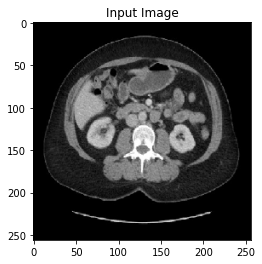

c:\Users\Pc\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


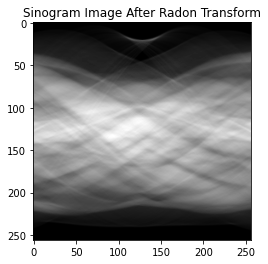

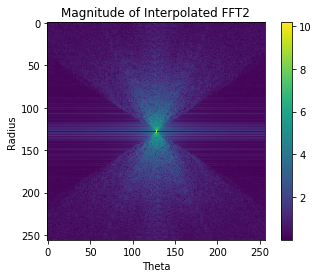

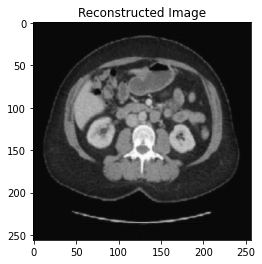

Mean Squared Error: 0.0014516950707262166


In [38]:
CTScan(input_image2)

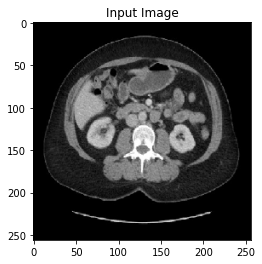

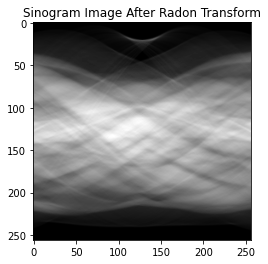

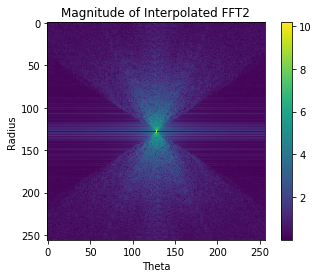

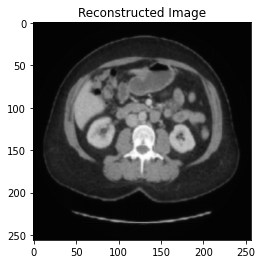

Mean Squared Error: 0.0012823701377916905


In [39]:
CTScan(input_image2, "ramp")

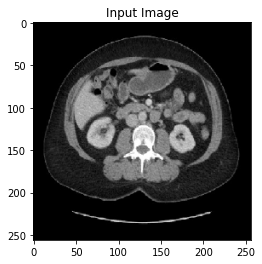

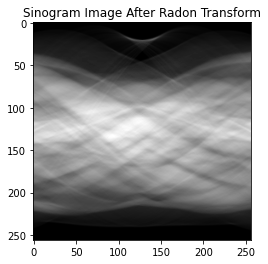

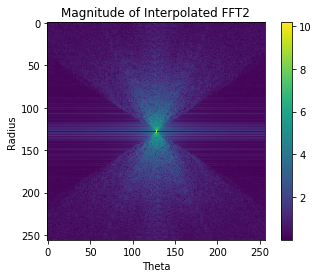

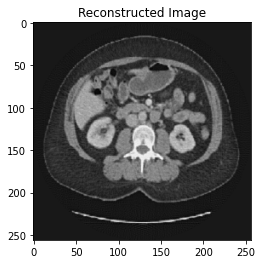

Mean Squared Error: 0.005430138758188569


In [40]:
CTScan(input_image2, "cosine")

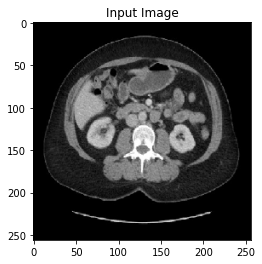

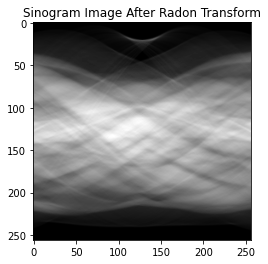

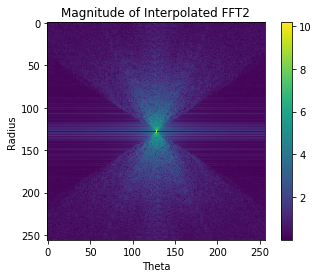

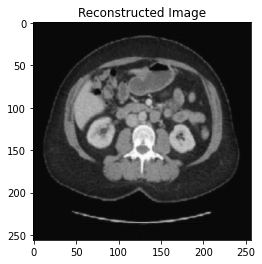

Mean Squared Error: 0.0014516950707262166


In [43]:
CTScan(input_image2, "cutoff_frequency", cutoff_freq= 90)

In [36]:
print("CTScan result without normalizing and cutoff_frequency filter=0.005:")
error_cutoff1= CTScan_withoutNormalizing(input_image, "cutoff_frequency", cutoff_freq= 0.005)
print()
print("CTScan result without normalizing and cutoff_frequency filter=0.05:")
error_cutoff2= CTScan_withoutNormalizing(input_image, "cutoff_frequency", cutoff_freq= 0.05)
print()
print("CTScan result without normalizing and cutoff_frequency filter=0.25:")
error_cutoff3= CTScan_withoutNormalizing(input_image, "cutoff_frequency", cutoff_freq= 0.25)
print()
print("CTScan result without normalizing and cutoff_frequency filter=0.5:")
error_cutoff4= CTScan_withoutNormalizing(input_image, "cutoff_frequency", cutoff_freq= 0.5)
print()
print("CTScan result without normalizing and cutoff_frequency filter=0:")
error_cutoff5= CTScan_withoutNormalizing(input_image, "cutoff_frequency", cutoff_freq= 0)
print()
print("CTScan result without normalizing and cutoff_frequency filter=45:")
error_cutoff6= CTScan_withoutNormalizing(input_image, "cutoff_frequency", cutoff_freq= 45)
print()
print("CTScan result without normalizing and cutoff_frequency filter=90:")
error_cutoff7= CTScan_withoutNormalizing(input_image, "cutoff_frequency", cutoff_freq= 90)
print()
print("CTScan result without normalizing and cutoff_frequency filter=135:")
error_cutoff8= CTScan_withoutNormalizing(input_image, "cutoff_frequency", cutoff_freq= 135)
print()

CTScan result without normalizing and cutoff_frequency filter=0.005:
Mean Squared Error: 0.06089778921566103

CTScan result without normalizing and cutoff_frequency filter=0.05:
Mean Squared Error: 0.060885027655772084

CTScan result without normalizing and cutoff_frequency filter=0.25:
Mean Squared Error: 0.060720346350414664

CTScan result without normalizing and cutoff_frequency filter=0.5:
Mean Squared Error: 0.05976598925644537

CTScan result without normalizing and cutoff_frequency filter=0:
Mean Squared Error: 0.060897958235802255

CTScan result without normalizing and cutoff_frequency filter=45:
Mean Squared Error: 0.0009416523761851609

CTScan result without normalizing and cutoff_frequency filter=90:
Mean Squared Error: 0.0009416523761851609

CTScan result without normalizing and cutoff_frequency filter=135:
Mean Squared Error: 0.0009416523761851609



In [37]:
print("CTScan result with normalizing and cutoff_frequency filter=0.005:")
error_cutoff1= CTScan_withNormalizing(input_image, "cutoff_frequency", cutoff_freq= 0.005)
print()
print("CTScan result with normalizing and cutoff_frequency filter=0.05:")
error_cutoff2= CTScan_withNormalizing(input_image, "cutoff_frequency", cutoff_freq= 0.05)
print()
print("CTScan result with normalizing and cutoff_frequency filter=0.25:")
error_cutoff3= CTScan_withNormalizing(input_image, "cutoff_frequency", cutoff_freq= 0.25)
print()
print("CTScan result with normalizing and cutoff_frequency filter=0.5:")
error_cutoff4= CTScan_withNormalizing(input_image, "cutoff_frequency", cutoff_freq= 0.5)
print()
print("CTScan result with normalizing and cutoff_frequency filter=0:")
error_cutoff5= CTScan_withNormalizing(input_image, "cutoff_frequency", cutoff_freq= 0)
print()
print("CTScan result with normalizing and cutoff_frequency filter=45:")
error_cutoff6= CTScan_withNormalizing(input_image, "cutoff_frequency", cutoff_freq= 45)
print()
print("CTScan result with normalizing and cutoff_frequency filter=90:")
error_cutoff7= CTScan_withNormalizing(input_image, "cutoff_frequency", cutoff_freq= 90)
print()
print("CTScan result with normalizing and cutoff_frequency filter=135:")
error_cutoff8= CTScan_withNormalizing(input_image, "cutoff_frequency", cutoff_freq= 135)
print()

CTScan result with normalizing and cutoff_frequency filter=0.005:
Mean Squared Error: 0.18340077021550552

CTScan result with normalizing and cutoff_frequency filter=0.05:
Mean Squared Error: 0.17687934322057167

CTScan result with normalizing and cutoff_frequency filter=0.25:
Mean Squared Error: 0.22666346706364257

CTScan result with normalizing and cutoff_frequency filter=0.5:
Mean Squared Error: 0.17452647812146832

CTScan result with normalizing and cutoff_frequency filter=0:
Mean Squared Error: 0.19674559800715366

CTScan result with normalizing and cutoff_frequency filter=45:
Mean Squared Error: 0.0026190583689824705

CTScan result with normalizing and cutoff_frequency filter=90:
Mean Squared Error: 0.0026190583689824705

CTScan result with normalizing and cutoff_frequency filter=135:
Mean Squared Error: 0.0026190583689824705

